In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [ ]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv("/content/drive/MyDrive/Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
#get only 2 columns - Text, Score
#drop the NAN values
reviews = reviews[['Text','Score']]


In [ ]:
#if score> 3, set score = 1
#if score<=2, set score = 0
#if score == 3, remove the rows. 
import math
def score_preprocessor(i):
  if i > 3 :
    return 1
  elif i <= 2 :
    return 0
  elif i == 3:
    return math.nan
reviews['Score'] = reviews['Score'].map(score_preprocessor)
reviews = reviews.dropna()

In [ ]:
reviews['Score']

0         1.0
1         0.0
2         1.0
3         0.0
4         1.0
         ... 
568449    1.0
568450    0.0
568451    1.0
568452    1.0
568453    1.0
Name: Score, Length: 525814, dtype: float64

In [ ]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [ ]:
import re

In [ ]:
#remove HTML from the Text column and save in the Text column only
reviews['Text'] = reviews['Text'].map(lambda x: re.sub(r'<.*?>', '', x))

In [ ]:
#print head 5
reviews.head()

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1.0,30
418112,My cat loves this. The pellets are nice and s...,1.0,31
357829,Great product. Does not completely get rid of ...,1.0,41
175872,This gum is my favorite! I would advise every...,1.0,27
178716,I also found out about this product because of...,1.0,22


In [ ]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 
from sklearn.model_selection import train_test_split
y = reviews['Score']
X = reviews.drop(['Score'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.3, random_state=33)

1.0    0.870043
0.0    0.129957
Name: Score, dtype: float64
1.0    0.870033
0.0    0.129967
Name: Score, dtype: float64


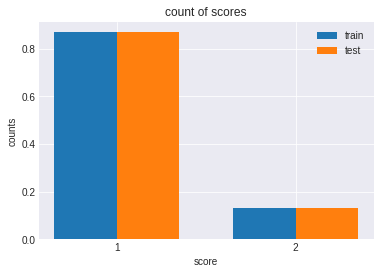

In [ ]:
#plot bar graphs of y_train and y_test
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
#plot bar graphs of y_train and y_test
fig, ax = plt.subplots()
width = 0.35
indices = np.arange(2)
counts = y_train.value_counts(normalize=True)
print(counts)
bar1 = ax.bar(indices, counts, width)
counts = y_test.value_counts(normalize=True)
print(counts)
bar2 = ax.bar(indices + width, counts, width)
ax.set_ylabel('counts')
ax.set_xlabel('score')
ax.set_title('count of scores')
ax.set_xticks(indices + width/2)
ax.set_xticklabels(['1', '2'])
ax.legend((bar1[0], bar2[0]), ('train', 'test'))
fig.show()

In [ ]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [ ]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[[input_word_ids], [input_mask], [segment_ids]], outputs=pooled_output)


In [ ]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [ ]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
!pip install sentencepiece
import tokenization #- #We have given tokenization.py file

In [ ]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
# if you are getting error for sentencepiece module you can install it using below command while running this cell for the first time

tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

In [ ]:

# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 
X_train_tokens = X_train['Text'].map(tokenizer.tokenize)
X_test_tokens = X_test['Text'].map(tokenizer.tokenize)
# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)
X_train_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_train_tokens, maxlen=max_seq_length-2,value='[PAD]', dtype=object)
X_test_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_test_tokens, maxlen=max_seq_length-2,value='[PAD]', dtype=object)
# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)
def tokenize_sequence(text):
  seq = []
  for row in text:
    seq.append(['[CLS]', *row, '[SEP]'])
  return np.array(seq)
X_train_tokens = tokenize_sequence(X_train_tokens)
X_test_tokens = tokenize_sequence(X_test_tokens)
# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask
X_train_mask = (X_train_tokens != '[PAD]')
X_test_mask = (X_test_tokens != '[PAD]')
# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)
X_train_segment = np.zeros(X_train_tokens.shape)
X_test_segment = np.zeros(X_test_tokens.shape)
# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment



In [ ]:
def convert_tokens_to_ids(text, tokenizer):
  ids = []
  for row in text:
    ids.append(tokenizer.convert_tokens_to_ids(row))
  return np.array(ids)


X_train_tokens = convert_tokens_to_ids(X_train_tokens, tokenizer)
X_test_tokens = convert_tokens_to_ids(X_test_tokens, tokenizer)

In [ ]:
import pickle

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [ ]:
#you can load from disk
#X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
#X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [ ]:
bert_model.input

[[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>],
 [<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>],
 [<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]]

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
#this cell will take some time to execute, make sure thay you have stable internet connection
X_train_pooled_output=bert_model.predict([[X_train_tokens],[X_train_mask],[X_train_segment]])

In [ ]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([[X_test_tokens],[X_test_mask],[X_test_segment]])

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [ ]:
X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric. Do not use tf.keras.metrics.AUC</b> 
<b> You have to write custom code for AUC and print it at the end of each epoch</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [ ]:
import pickle
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("/content/drive/MyDrive/train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("/content/drive/MyDrive/test_data.pkl", 'rb')) 
X_train_pooled_output, X_test_pooled_output= pickle.load(open('/content/drive/MyDrive/final_output.pkl', 'rb'))

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
y_train = OneHotEncoder().fit_transform(np.array(y_train).reshape(-1,1)).toarray()

In [ ]:
y_test = OneHotEncoder().fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [ ]:
##imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM, BatchNormalization,Flatten
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras.callbacks import (Callback, EarlyStopping,TensorBoard, ReduceLROnPlateau)

In [ ]:
from sklearn.metrics import roc_auc_score
def auc_score(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)
def auc(y_true, y_pred):
    return tf.py_function(auc_score, (y_true, y_pred), tf.double)

In [ ]:
input_layer=Input(shape=(X_train_pooled_output.shape[1],))
dense_layer_1 = Dense(64, activation='relu')(input_layer)
dense_layer_2 = Dense(32, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(16, activation='relu')(dense_layer_2)
output_layer = Dense(2, activation='softmax')(dense_layer_3)

model = tf.keras.Model(inputs=input_layer, outputs= output_layer)

reduce_lr = ReduceLROnPlateau(patience=3)
earlystop = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
tensor = tf.keras.callbacks.TensorBoard(log_dir='logs_bert', histogram_freq=0, write_graph=True,write_images=False, write_steps_per_second=False, update_freq='epoch')
adam = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=adam,metrics=['accuracy',auc])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 64)                49216     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 51,858
Trainable params: 51,858
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
class_weight = {0: 0.15602, 1: 0.84398}

In [ ]:
model.fit(X_train_pooled_output, y_train, batch_size=256,epochs=100, validation_data=(X_test_pooled_output,y_test),class_weight = {0: 0.16, 1: 0.84} ,callbacks=[tensor])

Epoch 1/100
274/274 [==============================] - 4s 14ms/step - loss: 0.0943 - accuracy: 0.8700 - auc: 0.7195 - val_loss: 0.4418 - val_accuracy: 0.8700 - val_auc: 0.8256
Epoch 2/100
274/274 [==============================] - 4s 13ms/step - loss: 0.0810 - accuracy: 0.8700 - auc: 0.8537 - val_loss: 0.3893 - val_accuracy: 0.8700 - val_auc: 0.8749
Epoch 3/100
274/274 [==============================] - 4s 13ms/step - loss: 0.0718 - accuracy: 0.8700 - auc: 0.8959 - val_loss: 0.3262 - val_accuracy: 0.8700 - val_auc: 0.9083
Epoch 4/100
274/274 [==============================] - 3s 11ms/step - loss: 0.0644 - accuracy: 0.8701 - auc: 0.9202 - val_loss: 0.3105 - val_accuracy: 0.8703 - val_auc: 0.9256
Epoch 5/100
274/274 [==============================] - 4s 13ms/step - loss: 0.0600 - accuracy: 0.8753 - auc: 0.9316 - val_loss: 0.3201 - val_accuracy: 0.8740 - val_auc: 0.9333
Epoch 6/100
274/274 [==============================] - 3s 11ms/step - loss: 0.0579 - accuracy: 0.8843 - auc: 0.9374 - va

<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 
1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a> </pre>


In [ ]:
#there is an alterante way to load files from Google drive directly to your Colab session
# you can use gdown module to import the files as follows
#for example for test.csv you can write your code as !gdown --id file_id (remove the # from next line and run it)

In [ ]:
#read the csv file
test_df= pd.read_csv('test.csv')

In [ ]:
test_df.head()

,Text
0,Just opened Greenies Joint Care (individually ...
1,This product rocks :) My mom was very happy w/...
2,"The product was fine, but the cost of shipping..."
3,I love this soup. It's great as part of a meal...
4,Getting ready to order again. These are great ...


<Pre>1. You have to write a function that takes the test_df,trained model and the required parameters as input. 
2. Perform all the preproceesing steps inside the function.
- Remove all the html tags
- Now do tokenization [Part 3 as mentioned above]
- Create tokens,mask array and segment array
- Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
- Print the shape of output(X_test.shape).You should get (352,768)
3. Predit the output of X_test with the neural network model which we trained earlier.

4. Return the occurences of class labels from the function.
The output should be the count of datapoints classified as 1 or 0.

</pre>

In [ ]:
def bert(X):
  X.map(lambda x: re.sub(r'<.*?>', '', x))
  tokens = X.map(tokenizer.tokenize)
  tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, max_seq_length - 2,value='[PAD]', dtype=object)
  tokens = tokenize_sequence(tokens)

  mask = (tokens != '[PAD]')
  segment = np.zeros(tokens.shape)
  tokens = convert_tokens_to_ids(tokens)
  return bert_model.predict([tokens, mask, tokens])
def tokenize_sequence(text):
  seq = []
  for row in text:
    seq.append(['[CLS]', *row, '[SEP]'])
  return np.array(seq)
def convert_tokens_to_ids(text):
  ids = []
  for row in text:
    ids.append(tokenizer.convert_tokens_to_ids(row))
  return np.array(ids)

In [ ]:
def pipeline(X,m):
  return m.predict(bert(X))

In [ ]:
pred = pipeline(test_df['Text'],model)

In [ ]:
pred = pd.DataFrame(pred)

In [ ]:
bert(test_df['Text']).shape

(352, 768)

In [ ]:
result = [1 if x > 0.5 else 0 for x in pred[1]]

In [ ]:
print(result)

[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 

##Steps




1.   First i loaded the data and took "text" and "score" column.
2.   Removed review text which had score=3 and remove review if text length is <50.
3.   Create a bert model, create tokens,masks,segmants.
4.   Train Bert model and get embeddings from the bert.
5.   Create a neural network and train it with the embeddings from bert for classification.
6.    After training nn for classification create a bert pipeline which does all the above steps for a given input.

